Lets take a visualised schem of the DES cipher so we can use it as a plan or would be better to say as an a skeleton of our implementation, which we will be wraping in skin and flash of functional code.

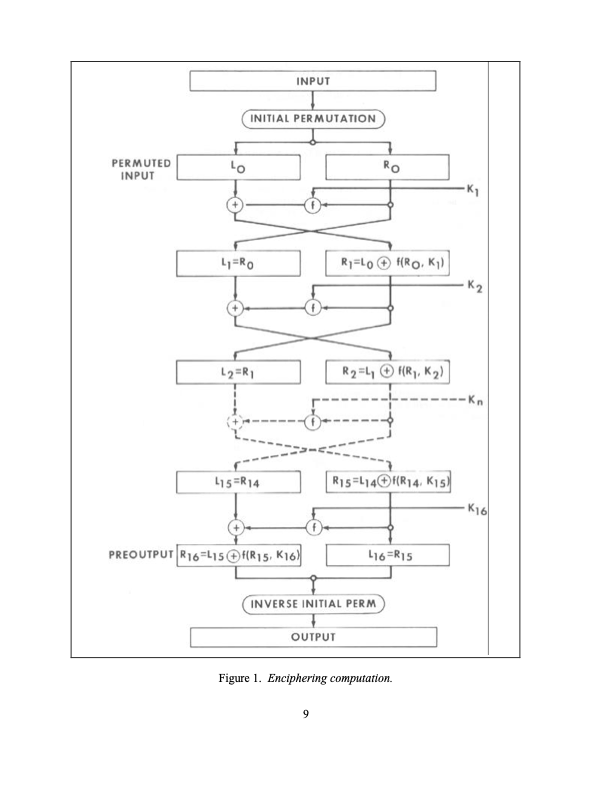

TODO: add to the start all previous code


In [ ]:
# Let's wrap a permutation logic into the function:
def permute(data, permutation_table):
  result = 0
  for new_position, old_position in enumerate(permutation_table):
    result |= (data >> old_position & 1) << new_position
  return result



In [ ]:
# TODO: add test to the function

Now when we have a permuted data we can see that we need to split it in two halves L (left) and R(right) of 32 bits each. Let's see first how it looks on the binary level and for an expample let's take a smaller data - 16 bits.

In [9]:
# let's take the number 180
a = 180
# now let's check it's binary representation:
print(f"{a:b}")


10110100


In [10]:
# now what we want to achive? we need to split it in two halves: L=1011 => 11, R = 0100 > 4
# Let's start with a left side. We will just move bytes to the right for setting half of the string to zeros.
L = a >> 4
print(f"L = {L:b}")

L = 1011


In [11]:
# the right side is a bit more tricky, but still easy to do.
# for this perpose we will use a mask (0xf)
R = a & 15
print(f"R = {R:04b}")

R = 0100


In [13]:
# Let's wrap it in spliting function:
def binary_split(data, size):
  L = data >> (size//2)
  R = (data & (2**(size//2) - 1))
  return L, R
L, R = binary_split(a, 8)
print(f"L = {L}, R = {R}")

L = 11, R = 4


In [ ]:
# TODO: add test to the function

Good job! Now we have everything what we need to the start! Now we can go deeper and touch a real magic. In the next step we start real encryption. And it consist of 2 elements: the round key and the encryption function itself. Let's start with a key

As you can see on our schema we will make 16 rounds - 16 partial encryption of our data. And for every round we need a unique key. Unique is the key word here. We can't just use our key every time, because it will not bring anybenefits and in fact will be just one round executed 16 times. we want to have a unique key, to have a unique encrytion on every round, it adds more security and randomnsess in our cipher.

Let's see now how we can convert one key into 16 unique keys in a deterministic way. And for this let's reference to the schema from the specification which gives us  big picture of how it should work: 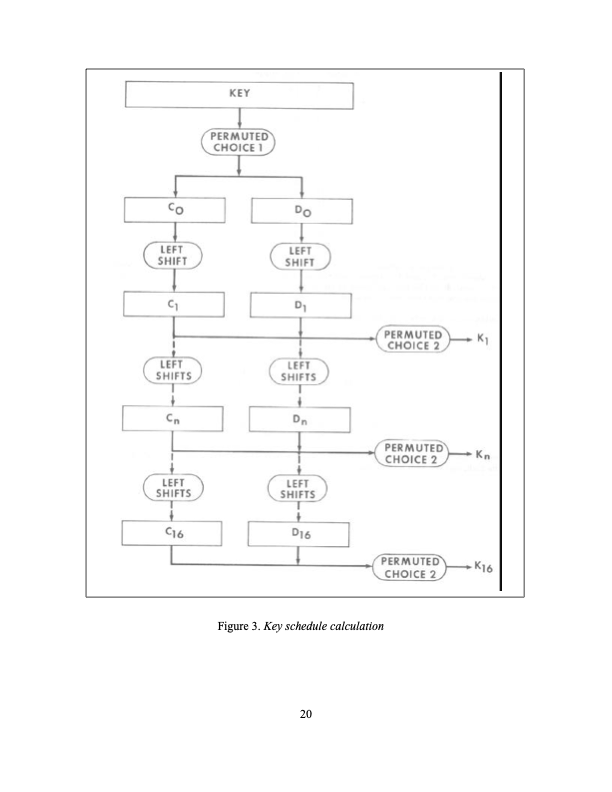

For that we will implement next parts:
1) Permuted choise 1
2) Left shift
3) Permuted choise 2

Let's start with Permuted choise 1.

In [14]:
# Now lets define the first permutation table:
PC_1 = [57, 49, 41, 33, 25, 17, 9,
1, 58, 50, 42, 34, 26, 18,
10, 2, 59, 51, 43, 35, 27,
19, 11, 3, 60, 52, 44, 36,

63, 55, 47, 39, 31, 23, 15,
7, 62, 54, 46, 38, 30, 22,
14, 6, 61, 53, 45, 37, 29,
21, 13, 5, 28, 20, 12, 4 ]



In [19]:
# Let's use our permutation function to permute the key folowing the permutation schema:
key = 180

permuted_key = permute(key, PC_1)

print(f"Permuted key: {permuted_key}")


Permuted key: 38280631192420352


In [20]:
# and let's split it on two halves for C and D parts:
C, D = binary_split(permuted_key, 64)
print("C: ", C)
print("D: ", D)

C:  8912904
D:  32768


When the first part is done we need to make a shift. shift depends on the iteration number. and uses the shift table to define of how many shifts should be done. Let's define the shift table:

In [21]:
SHIFTS_TABLE = [1,1,2,2,2,2,2,2,1,2,2,2,2,2,2,1]

In [23]:
# And make the shift for the C and D
current_iteration = 0
C = C << SHIFTS_TABLE[current_iteration]
D = D << SHIFTS_TABLE[current_iteration]

print("C: ", C)
print("D: ", D)

C:  35651616
D:  131072


And before wrap it in the function the last step is left - permuted choice 2:

Let's define the PC_2 table:

In [24]:
PC_2 = [
    14, 17, 11, 24, 1, 5,
    3, 28, 15, 6, 21, 10,
    23, 19, 12, 4, 26, 8,
    16, 7, 27, 20, 13, 2,
    41, 52, 31, 37, 47, 55,
    30, 40, 51, 45, 33, 48,
    44, 49, 39, 56, 34, 53,
    46, 42, 50, 36, 29, 32
]

In [26]:
# Now we need to join C and D and permute the result based on the table:
CD = (C << 28) | D

print("CD: ", CD)
permuted_CD = permute(CD, PC_2)

print("Permuted CD: ", permuted_CD)

CD:  9570157798227968
Permuted CD:  2353642078210


Let's wrapt it into one function and make it a generator, that returns the next round key on every call.

In [50]:
def key_scheduler(key):
    permuted_key = permute(key, PC_1)
    C, D = binary_split(permuted_key, 48)
    for i in range(16):
        C = C << SHIFTS_TABLE[i]
        D = D << SHIFTS_TABLE[i]
        CD = (C << 28) | D
        yield permute(CD, PC_2)


In [ ]:
# TODO: add test to the function

In [51]:
# Let's see what we get:
key_gen = key_scheduler(180)
for _ in range(16):
    print(next(key_gen))

551903559680
16777218
8192
8589935616
268439552
137438953472
4296015872
72567767433216
1073741824
141287244169216
1099511627776
35184372088832
0
2147483648
8796093022208
0


And now we are getting to the core of the cipher - The Cipher Function f. Let's take a look at the sketch of the function:

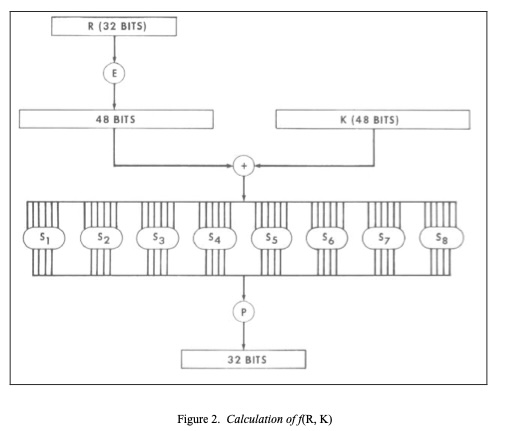

TODO: If you feel difficulties with a bit manipulation, please feel free to expand this section and see it in more details. If you want to know more about bit manipulation in general- feel free to let me know here: